##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">Przykład 3 DO LABORATORIUM 3</style></h1>
    <h1 style = "font-size:24px">z UCZENIA MASZYNOWEGO</style></h1>
    <h1 style = "font-size:24px">Klasyfikacja nienadzorowana</style></h1>
    <h1 style = "font-size:24px">Adam Kurowski</style></h1>
    <h3 style = "font-size:21px">Porównanie jakości segmentacji tekstu za pomocą algorytmu k średnich, <br/>hierarchicznego i bazującego na gęstości punktów (DBSCAN)</h3>
    <h3 style = 
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

![stopka.svg](stopka.svg)

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Przykład 3.: Porównanie jakości segmentacji tekstu za pomocą algorytmu k średnich, hierarchicznego i bazującego na gęstości punktów (DBSCAN)

## Przygotowanie danych wejściowych

W tym przykładzie zajmiemy się badaniem zachowania się algorytmów klasyfikacji nienadzorowanej w przypadku zastosowania tego typu narzędzi do segmentacji pisma. Klasyfikacja nienadzorowana jest w takim przypadku niezbędba, jeżeli nie zakładamy z góry, jakimi znakami posługuje się osoba wykonująca dany zapis. Nie możemy zatem przeprowadzić klasyfikacji nadzorowanej, jednak nadal możemy posłużyć się algorytmem działającym w sposób nienadzorowany do podzielenia poszczególnych obszarów zapisu na pojedyncze znaki.

In [1]:
# Import bibliotek
import numpy as np  # obliczenia numeryczne
import pandas as pd  # przetwarzanie danych "tabelarycznych"
import matplotlib.pyplot as plt  # wizualizacja danych
from sklearn.datasets import make_blobs, make_circles, make_moons  # zbiory danych
from sklearn.decomposition import PCA  # redukcja wymiarowości
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN  # implementacja algorytmów klasyfikacji
# nienadzorowanej
import scipy.cluster.hierarchy as sch  # procedury potrzebne do wizualizacji działania algorytmów hierarchicznych
from PIL import Image  # biblioteka do wczytywania i przetwarzania obrazów
import matplotlib.cm as cm  # dodatkowe palety kolorów - do łatwego ich nadawania efektom klasteryzacji w których
# generuje się bardzo dużo klastrów

Na potrzeby przykładu posłużymy się dwoma obrazkami zawierającymi pismo. Pierwszy z nich (logo.png) zawiera odręcznie narysowane logo fikcyjnej firmy. Drugi (wzor_matematyczny.png) zawiera przykład wzoru matematycznego.

Text(0.5, 1.0, 'Podgląd wejściowego obrazka zawierającego próbkę pisma')

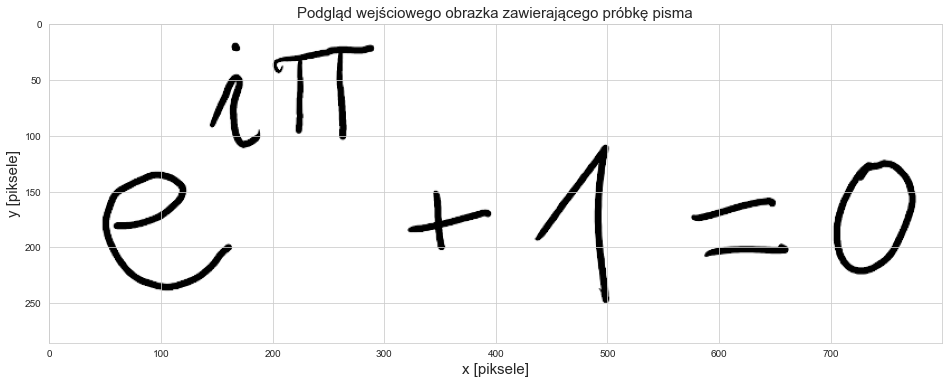

In [22]:
# Załadowanie danych z wybranego obrazka zawierającego próbkę pisma:
image = Image.open("wzor_matematyczny.png")  # logo fikcyjnej firmy
# image = Image.open("wzor_matematyczny.png") # wzór matematyczny

# Wyświetlenie podglądu danych oryginalnych
plt.figure(figsize=(16, 9))
plt.imshow(image)
plt.xlabel('x [piksele]', fontsize=15)
plt.ylabel('y [piksele]', fontsize=15)
plt.title('Podgląd wejściowego obrazka zawierającego próbkę pisma', fontsize=15)

Dane w postaci kolorowej grafiki (pomimo czarno-białej szaty graficznej zawiera ona kanały R,G,B i A) nie nadają się do dalszego przetwarzania. Konieczna jest konwersja grafiki do formatu czarno-białego i odszukanie tych pikseli, które są czarne. 

Text(0.5, 1.0, 'Podgląd przetworzonego obrazka wejściowego w postaci chmury punktów reprezentujących pismo')

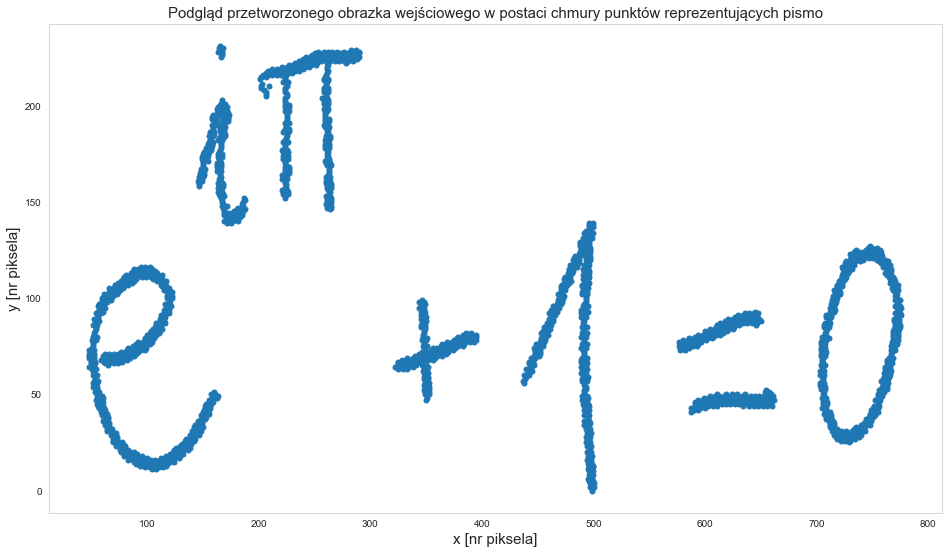

In [23]:
# Konwersja grafiki do formatu czarno-białego (bez szarości).
image_bw = np.array(image.convert('1'))

# Odszukanie współrzędnych, dla których piksel jest czarny
coords = np.where(image_bw == 0)

# Współrzędne mają w obrazkach w bibliote Pillow inny układ współrzędnych niż ten, z którego potem będziemy
# korzystać w bibliotece scikit-learn, dlatego tutaj musimy zamienić je kolejnością, oraz musimy "odwrócić"
# oś y.
dataset = np.vstack([coords[1], np.max(coords[0]) - coords[0]]).T

# Dodatkowo zmniejszymy czterokrotnie ilość danych, aby przyspieszyć obliczenia.
dataset = dataset[::4, :]

# Po wykonaniu wszystkich czynności przygotowawczych, wyświetlamy efekt wykonania kodu.
plt.figure(figsize=(16, 9))
plt.scatter(dataset[:, 0], dataset[:, 1], s=25)
plt.grid()
plt.xlabel('x [nr piksela]', fontsize=15)
plt.ylabel('y [nr piksela]', fontsize=15)
plt.title('Podgląd przetworzonego obrazka wejściowego w postaci chmury punktów reprezentujących pismo', fontsize=15)


## Algorytm k średnich
<p>Zadaniem do wykonania w ramach przykładu jest takie przeprowadzenie klasyfikacji nienadzorowanej, aby do każdej klasy trafił pojedynczy znak pisma (ewentualnie fragment znaku, tak jak kropka w literze i). Na początek zbadamy, jak z tym zadaniem poradzi sobie algorytm k średnich. Pierwszy krok to oczywiście wyznaczenie najlepszej wartości $k$.</p>

Text(0, 0.5, 'druga pochodna inercji')

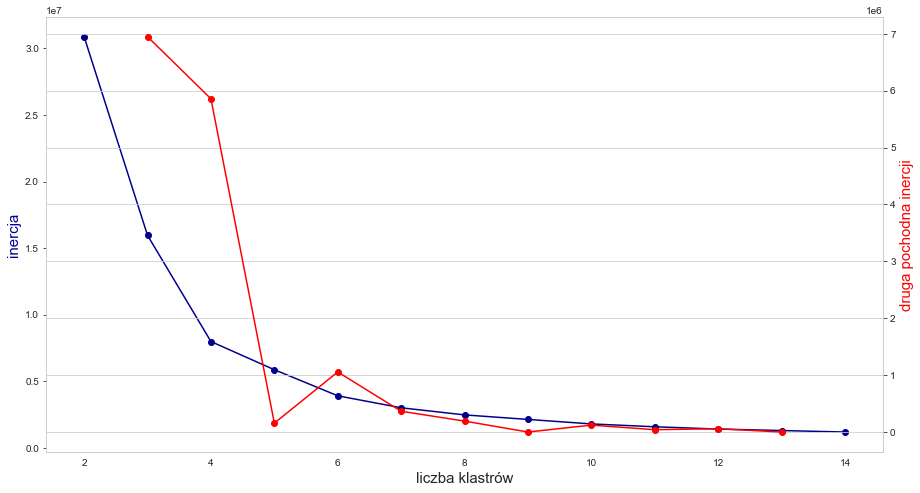

In [24]:
# Listy w których będziemy zapisywać poszczególne wartości parametru k i odpowiadających im wartości 
# metryki uśredninej odległości pomiędzy punktami.
k_values = []
intertia_scores_vec = []

# Następnie w pętli wywołujemy algorytm k średnich i zapisujemy wartości k oraz intercji.
# Tym razem wykorzystamy domyślne nastawy pracy algorytmu przyjęte w bibliotece scikit-learn.
for k in range(2, 15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(dataset)
    intertia_scores_vec.append(clusterer.inertia_)
    k_values.append(k)

# Na koniec rysujemy wykres inercji w funkcji liczby klastrów k.
fig = plt.figure(figsize=(15, 8))
plt.plot(k_values, intertia_scores_vec, marker='o', c='darkblue')
plt.grid()

# Na dodatkowej (prawej) osi y narysujemy drugą pochodną funkcji inercji, co pozwoli łatwiej odnaleźć punkt 
# gdzie dynamika zmian inercji (przyspieszenie) jest możliwie mała. W najlepszym przypadku - będzie to minimum
# modułu drugiej pochodnej.
ax1 = plt.gca()
ax2 = ax1.twinx()
module_of_second_derivative = np.abs(np.diff(np.diff(intertia_scores_vec)))
ax2.plot(k_values[1:-1], module_of_second_derivative, marker='o', color='red')

# Opis osi
ax1.set_xlabel('liczba klastrów', fontsize=15)
ax1.set_ylabel('inercja', color='darkblue', fontsize=15)
ax2.set_ylabel('druga pochodna inercji', color='red', fontsize=15)


Wyniki widoczne na wykresie inercji nie są jednoznaczne, konieczne będzie wypróbowanie kilku wartości parametru $k$. Minima  drugiej pochodnej inercji widoczne są dla $ k \in [7,9,12]$. Na początek, spróbujmy wypróbować wartość 7.

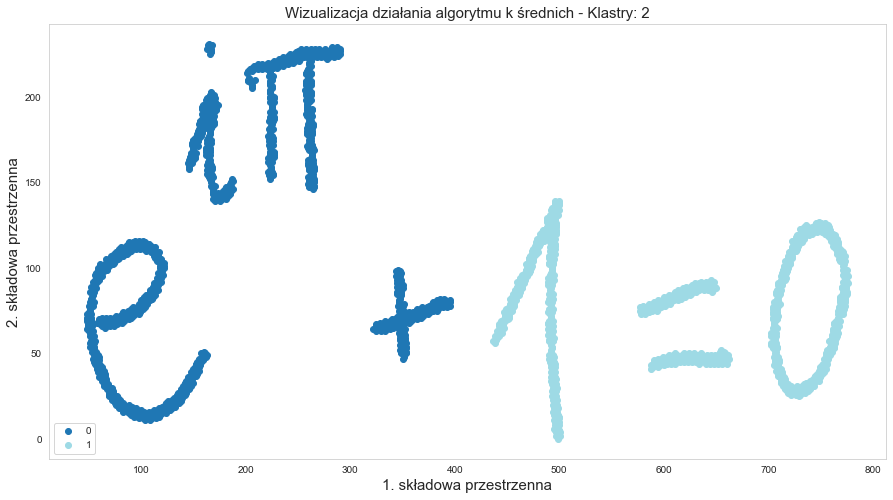

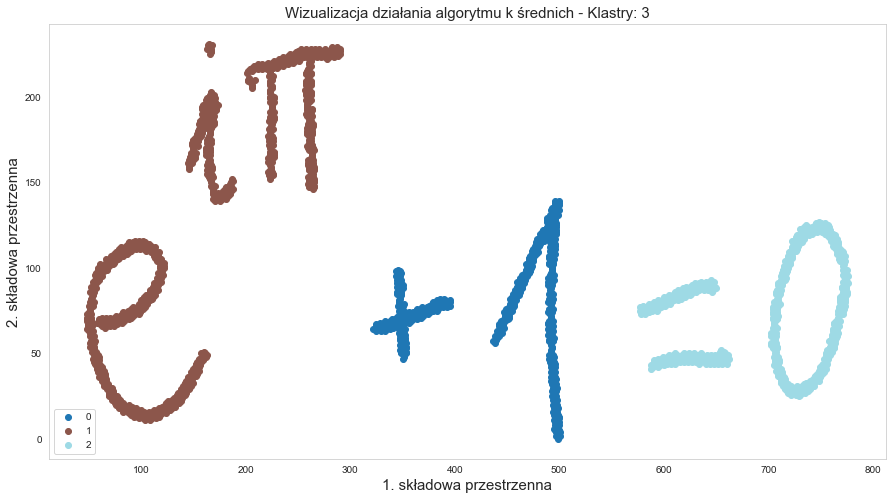

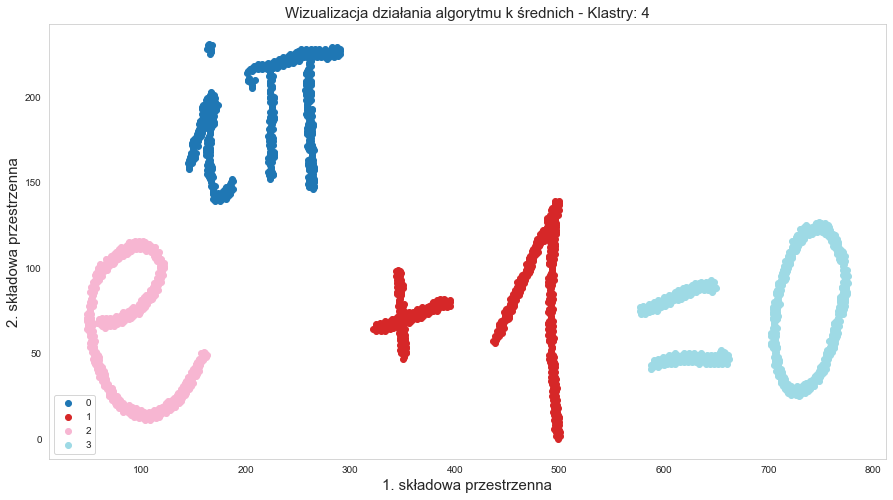

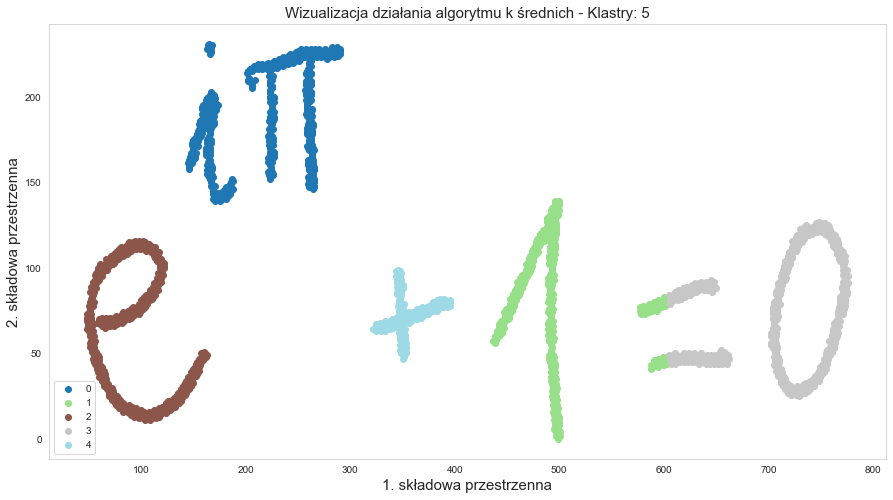

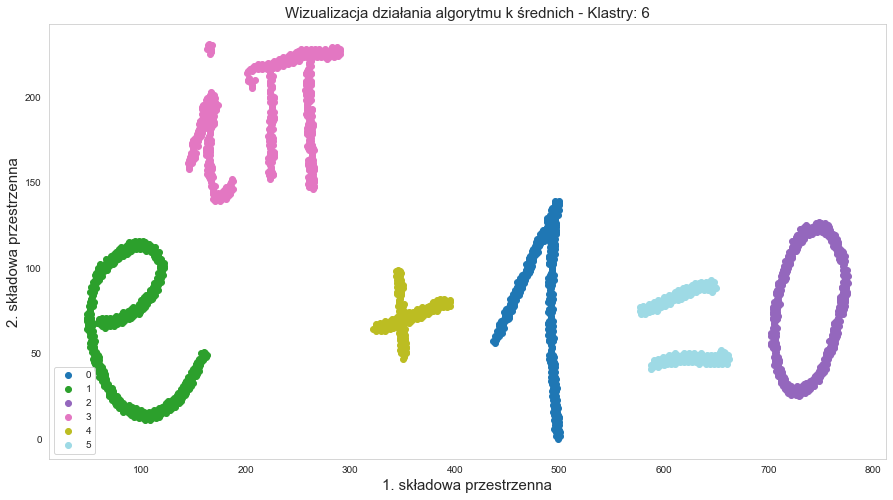

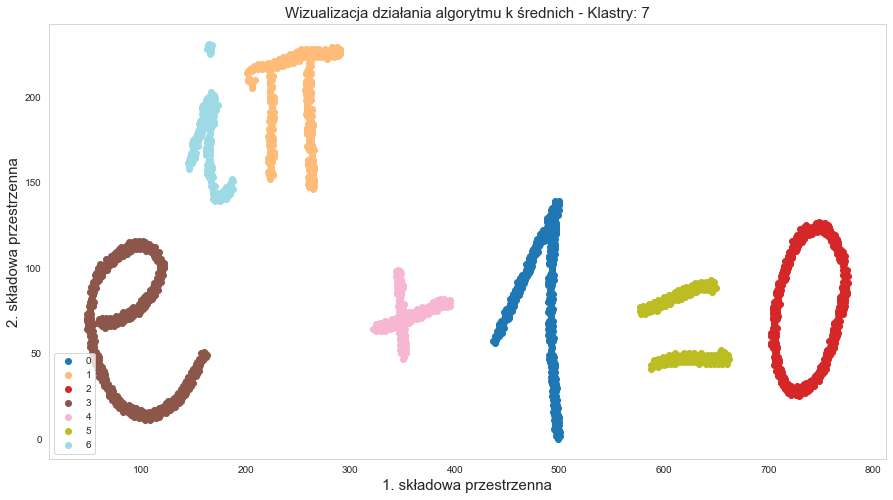

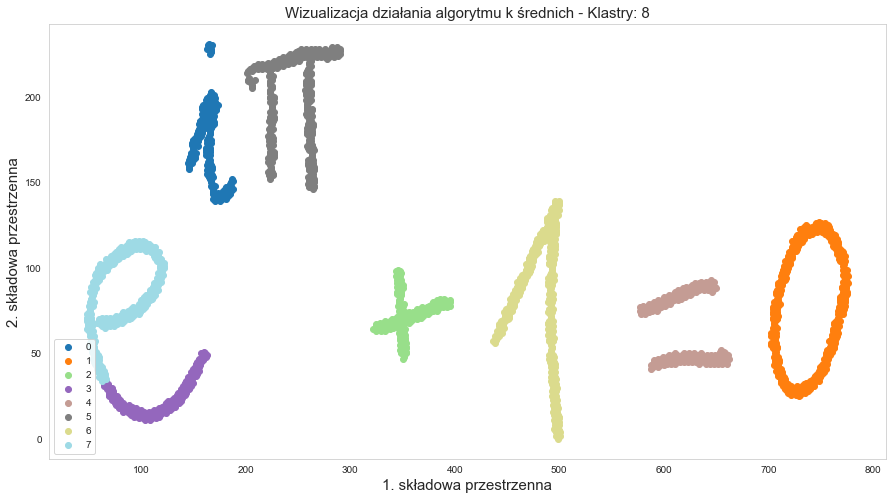

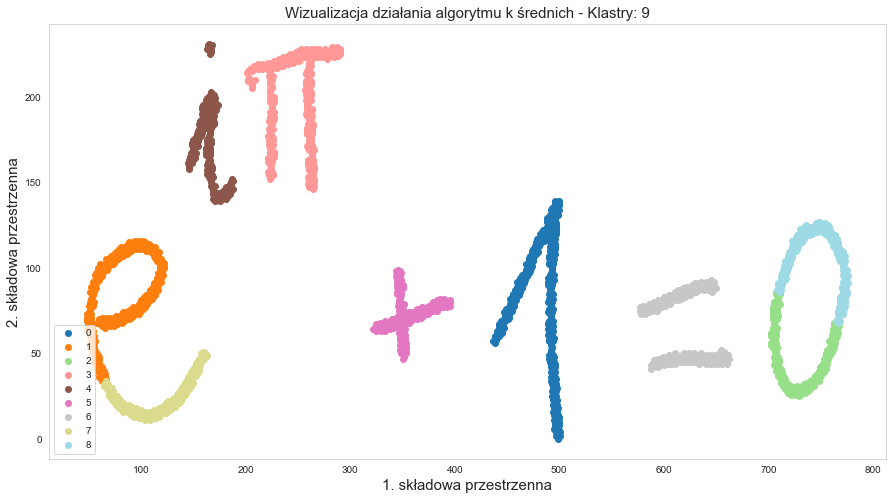

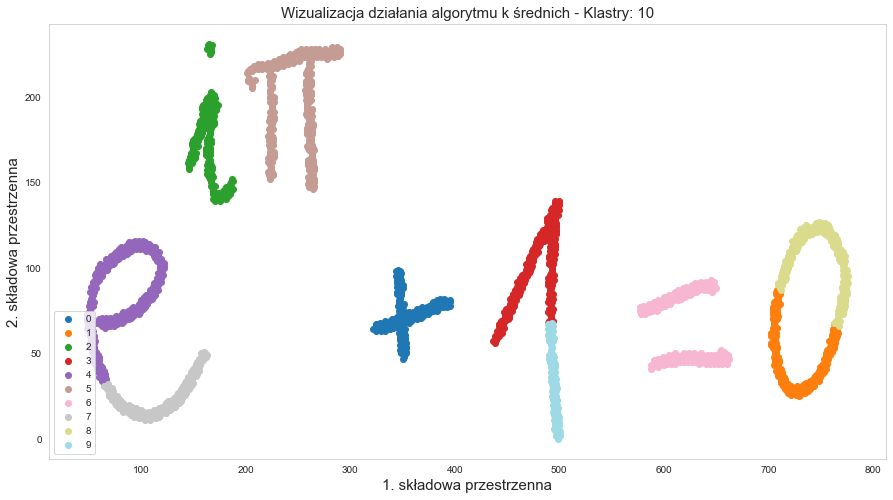

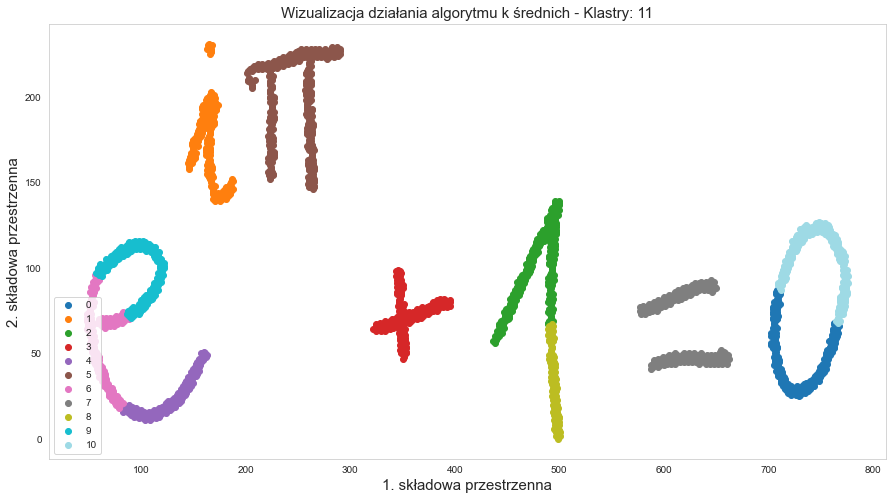

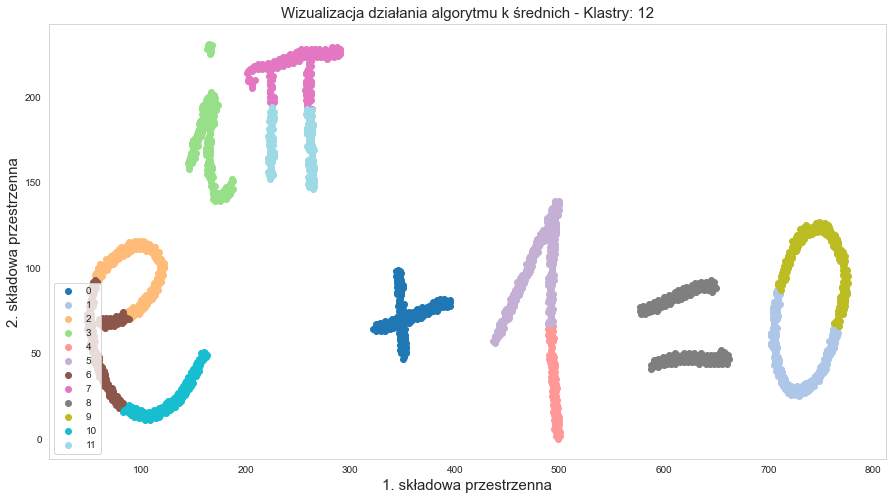

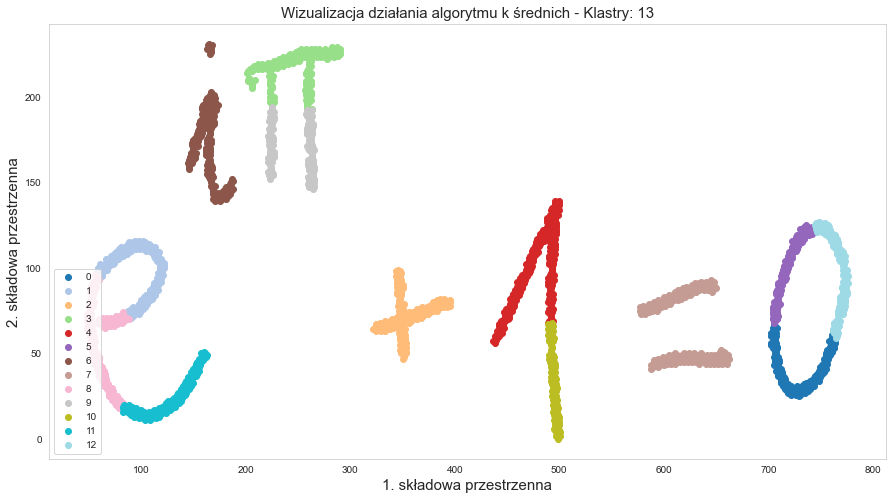

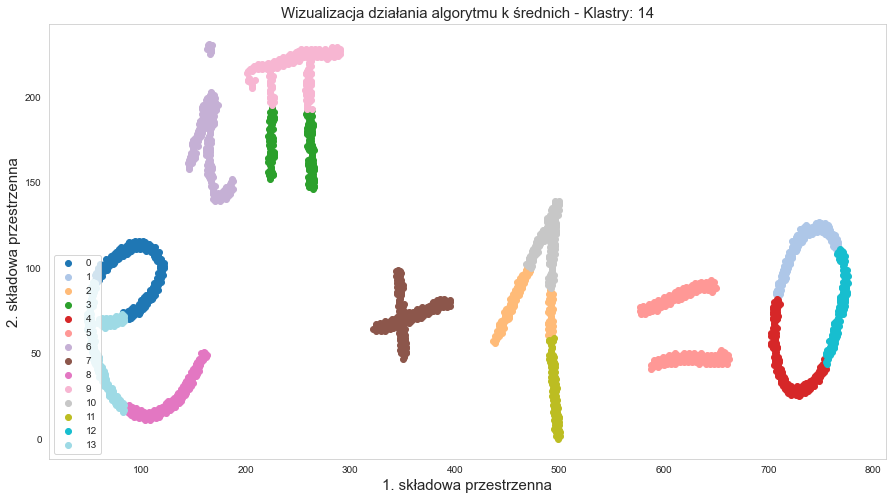

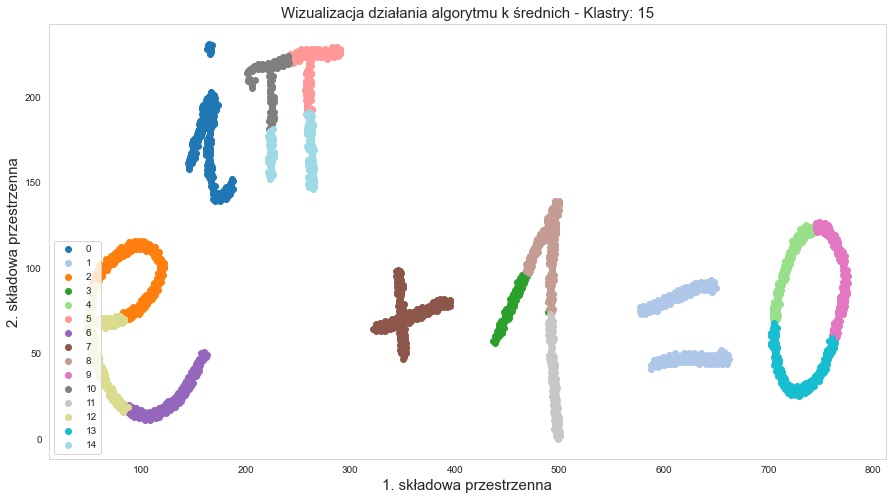

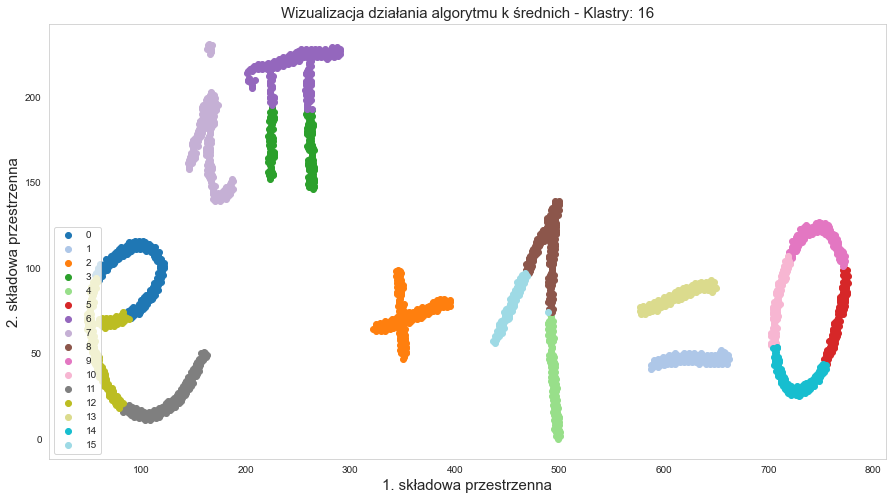

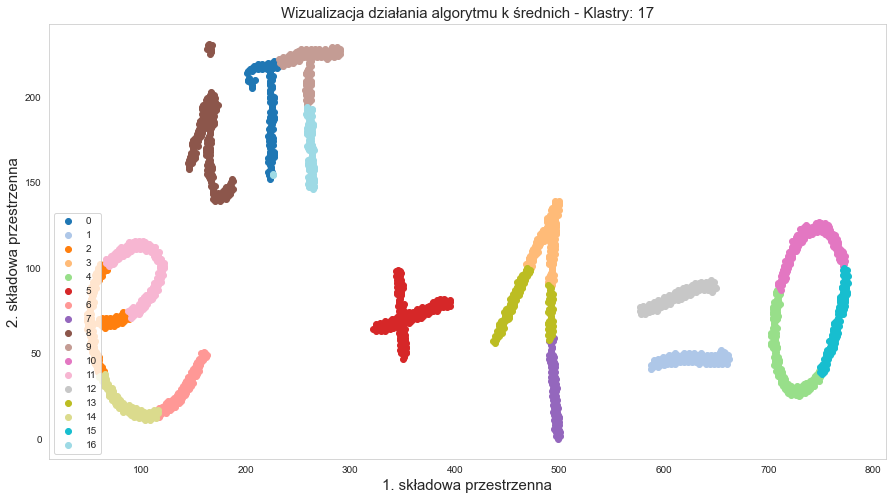

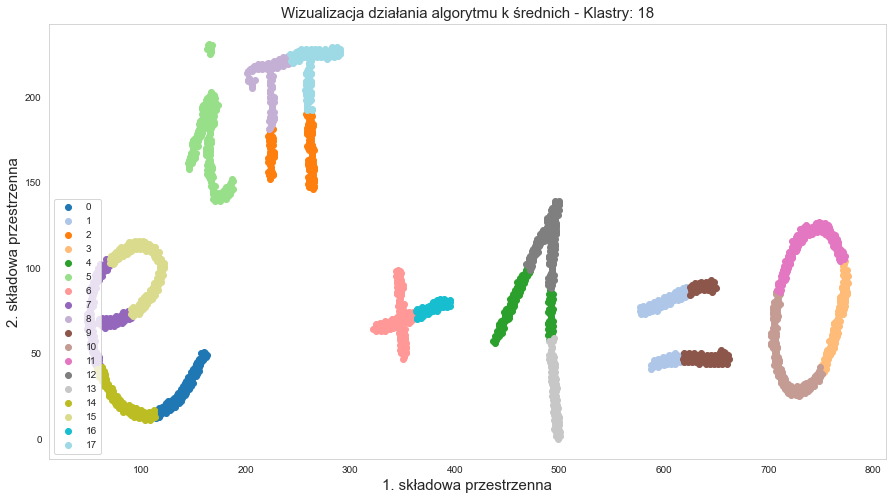

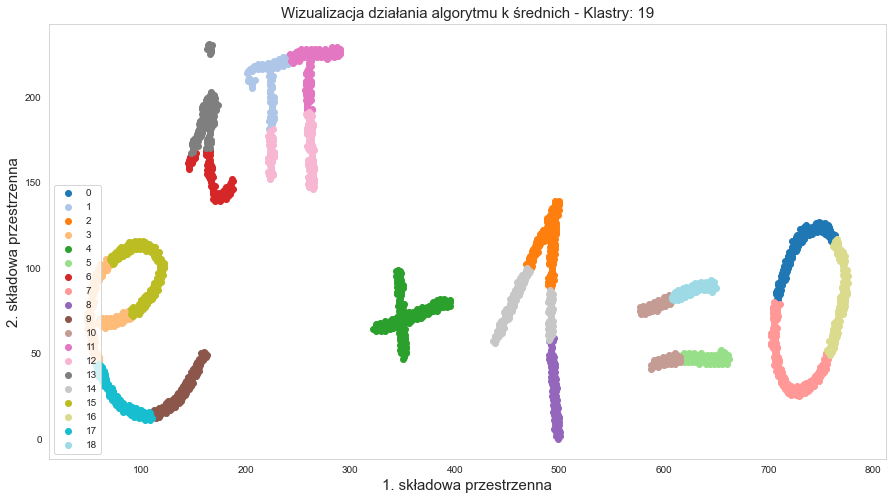

In [25]:
# Liczba klastrów, której się spodziewamy na podstawie wykresu inercji.
n_clusters = 7

for n_clusters in range(2, 20):
    # Wykonanie algorytmu k średnich
    clusterer = KMeans(n_clusters=n_clusters)
    clusterer.fit(dataset)
    k_means_predictions = clusterer.predict(dataset)

    # Wizualizacja za pomocą wcześniej wprowadzonej już funkcji plot_decision_regions.
    plt.figure(figsize=(15, 8))
    colors = cm.tab20(np.linspace(0, 1, len(np.unique(k_means_predictions))))
    # Narysujemy wykres punktowy z rozdzieleniem danych na klasy.
    for val, cv in zip(np.unique(k_means_predictions), colors):
        # Generujemy maskę za pomocą której wybierzemy punkty należące do każdej z klas.
        mask = k_means_predictions == val
        plt.scatter(dataset[mask, 0], dataset[mask, 1], label=val, color=cv)

    # Oznaczenie osi i dodatkowe elementy wykresu.
    plt.xlabel('1. składowa przestrzenna', fontsize=15)
    plt.ylabel('2. składowa przestrzenna', fontsize=15)
    plt.title(f"Wizualizacja działania algorytmu k średnich - Klastry: {n_clusters}", fontsize=15)
    plt.grid()
    plt.legend(loc='lower left', fontsize=10)

Ramka okalająca napis jest podzielona pomiędzy wiele klastrów, klastry zawierające wiele liter zawierają nie tylko całe litery, ale i fragmenty liter sąsiednich. W ramach dalszych zadań konieczne będzie sprawdzenie wyższych wartości parametru $k$.

## Algorytm hierarchiczny
<p> Warto wypróbować także algorytm hierarchiczny. Podobnie jak dla algorytmu k średnich tu także konieczna będzie decyzja odnośnie tego, jaką liczbę klastrów wybrać. Rozpocząć zatem należy od narysowania dendrogramu. Warto sprawdzić, jak on wygląda dla różnych metryk łączenia punktów w klastry. Zacznijmy od sprawdzenia, jak algorytm działa, gdy wybrana jest metryka Warda.</p>

Text(0.5, 1.0, 'dendrogram algorytmu hierarchicznego dla metryki: ward')

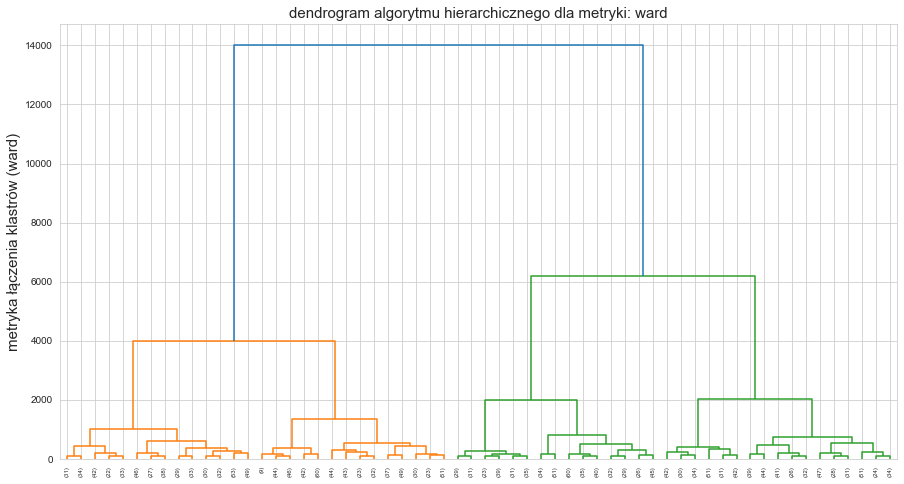

In [26]:
# Dostępne metryki łączenia klastrów:
#    'ward'     - metryka minimalizująca wariancję łączonych klastrów
#    'average'  - maksymalizuje średni dystans pomiędzy punktami 
#                 w różnych klastrach
#    'complete' - minimalizuje maksymalną odległość 
#                 między punktami w klastrach
#    'single'   - maksymalizuje najmniejszą odległość
#                 między punktami w klastrach

# Wybieramy metrykę według której łączymy poszczególne punkty danych
linkage_method = 'ward'

# Rysujemy dendrogram
plt.figure(figsize=(15, 8))
dend = sch.dendrogram(sch.linkage(dataset, method=linkage_method), truncate_mode='lastp', p=60)
plt.ylabel(f'metryka łączenia klastrów ({linkage_method})', fontsize=15)
plt.title(f'dendrogram algorytmu hierarchicznego dla metryki: {linkage_method}', fontsize=15)


Oceniając wizualnie dendrogram - potencjalnie liczna klastrów może wynosić 2, albo 4. Spróbujmy wypróbować wartość 4.

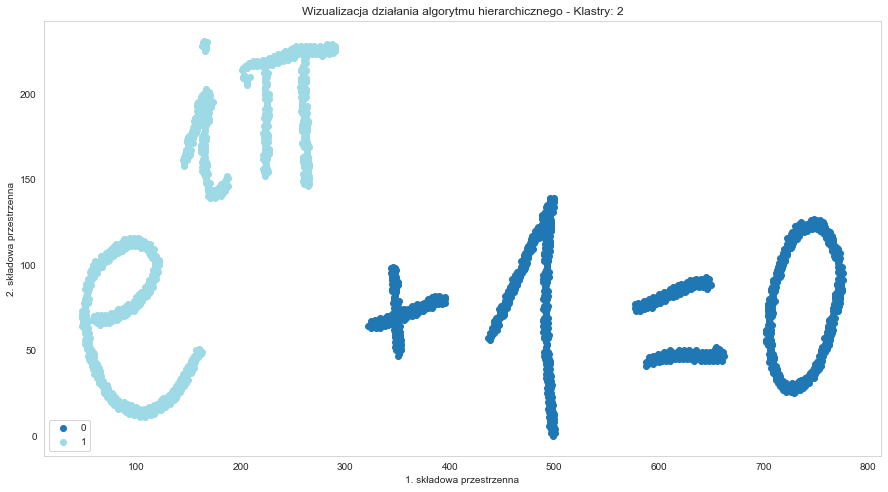

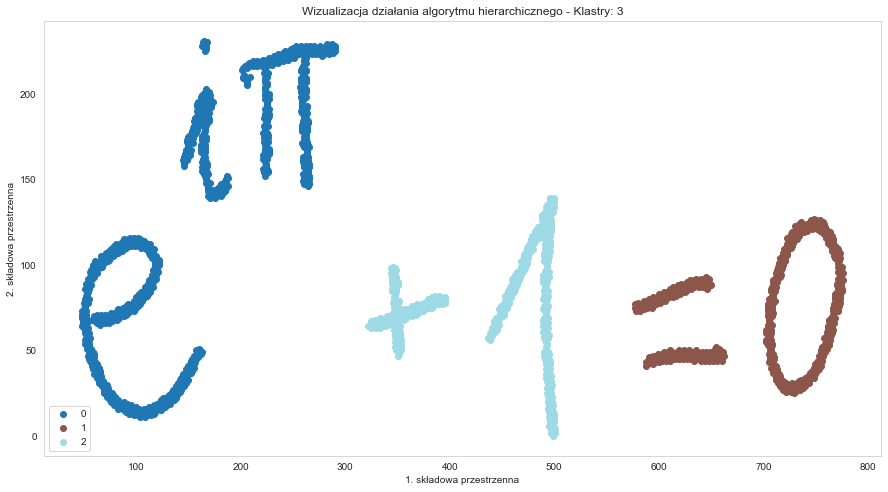

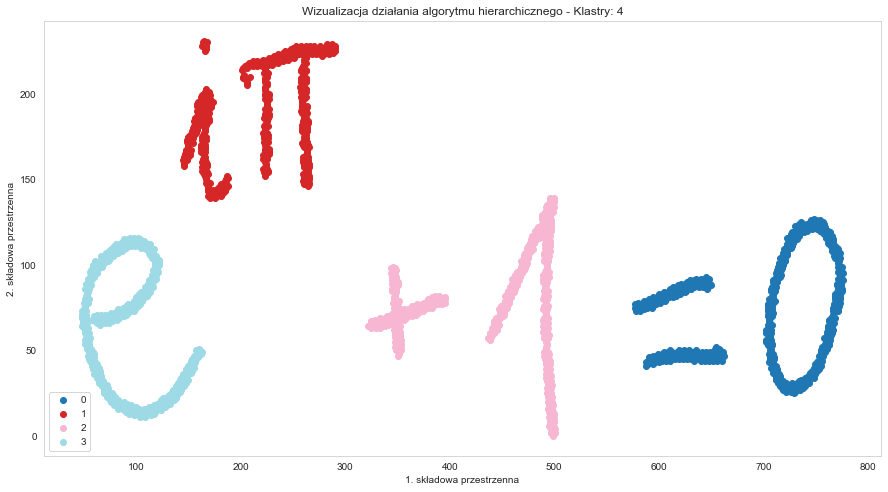

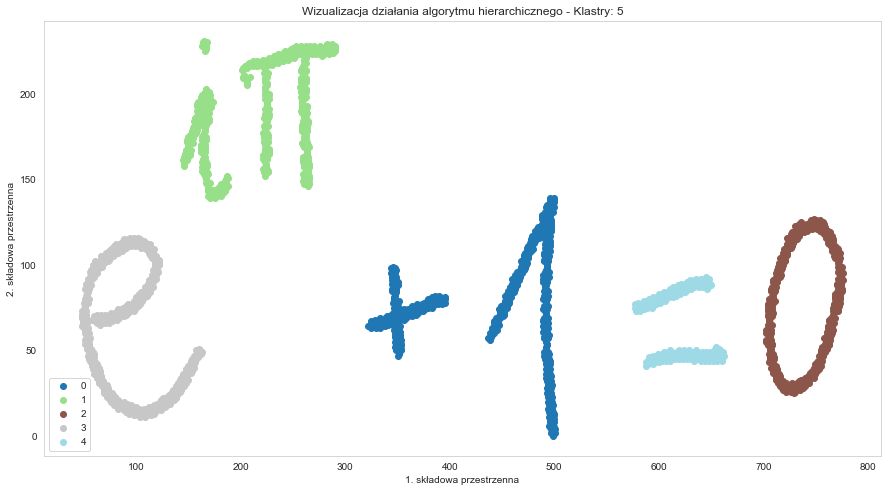

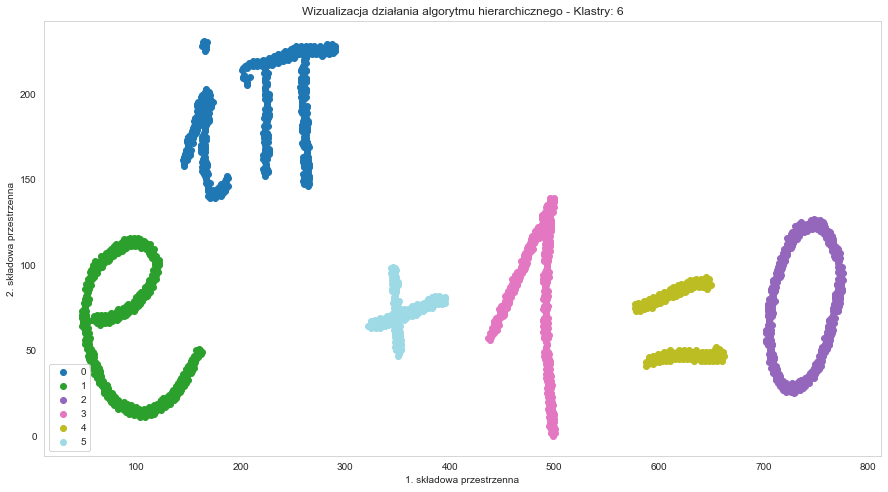

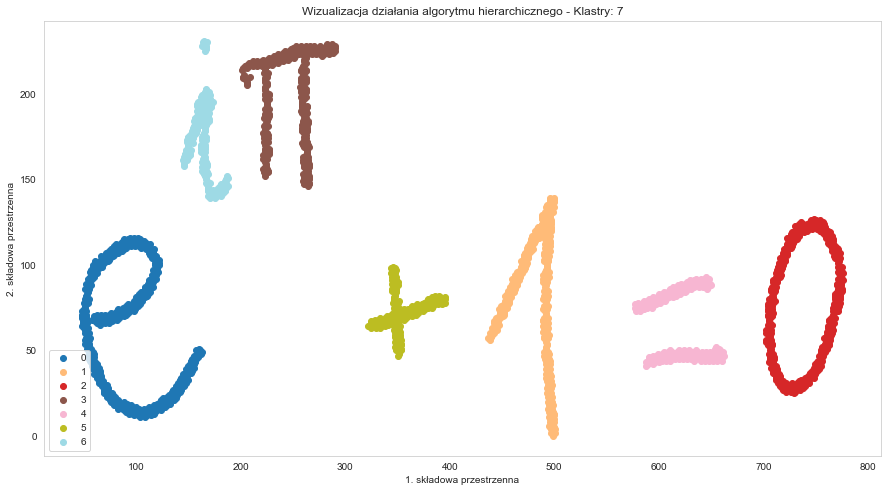

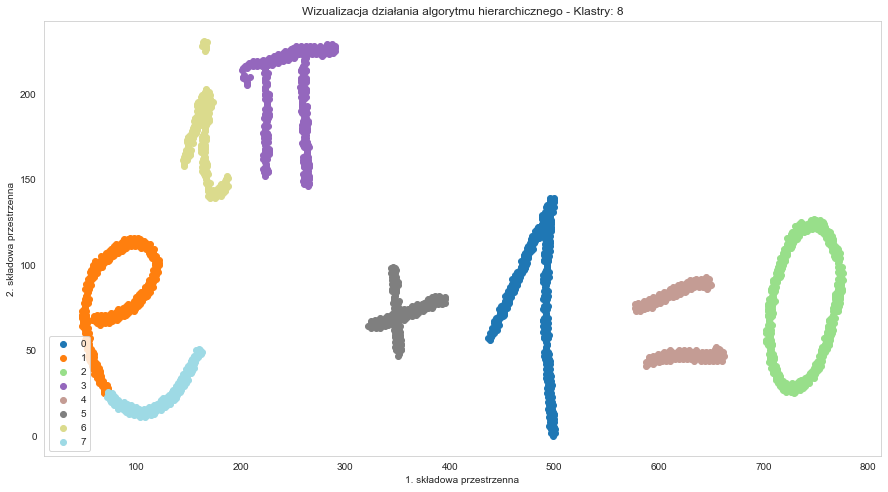

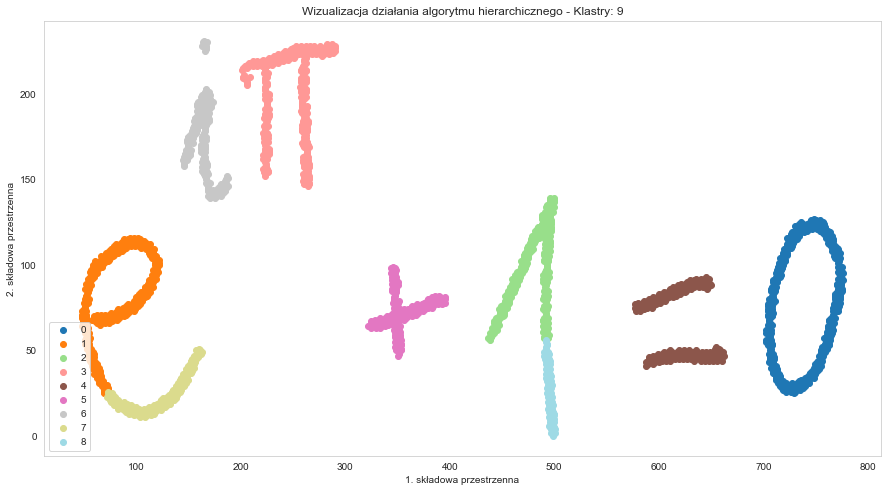

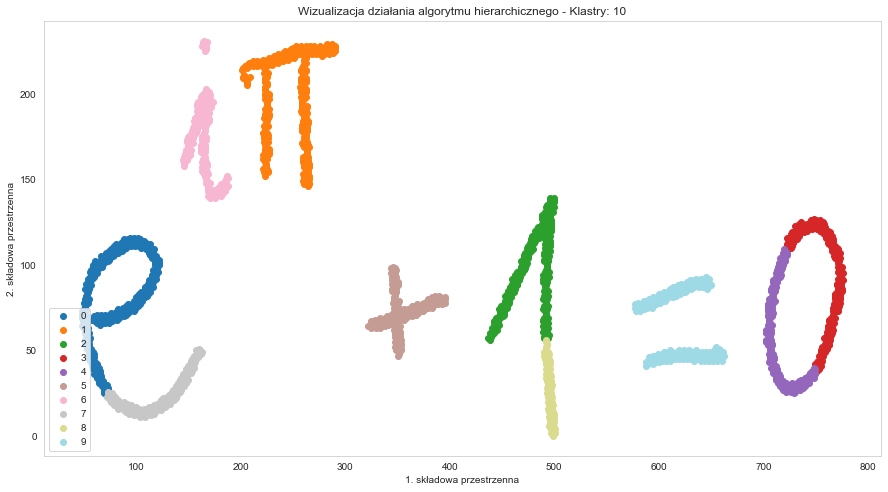

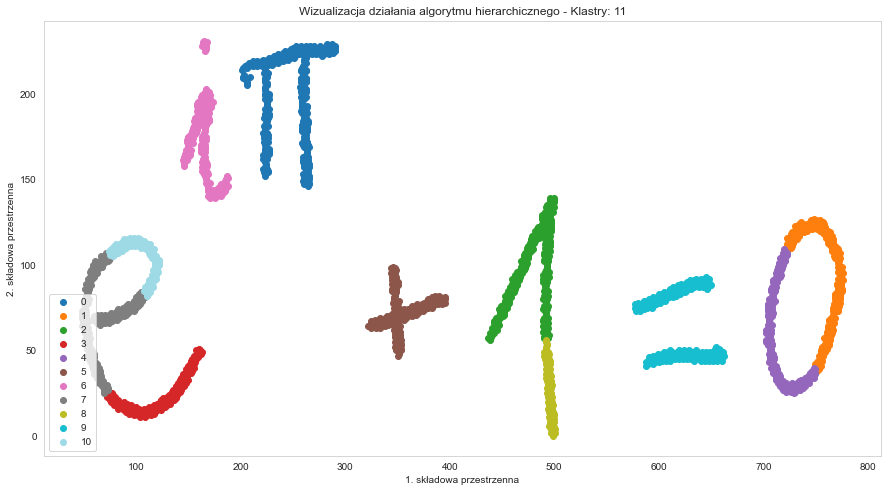

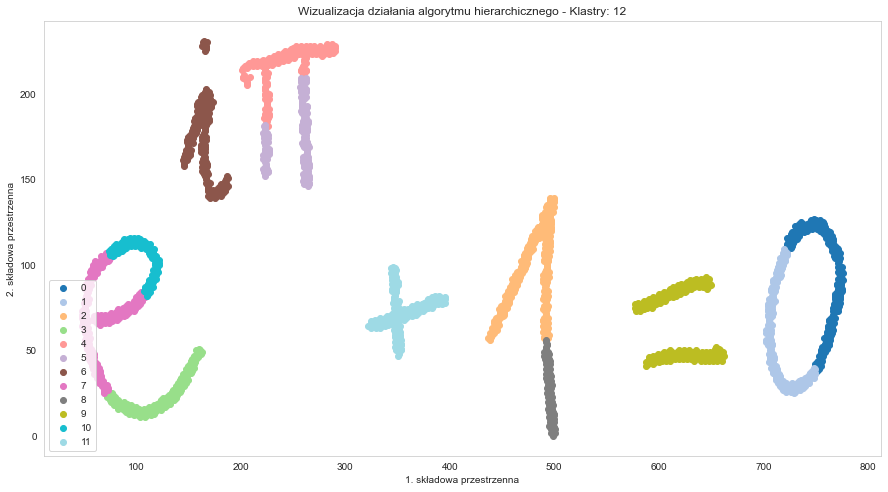

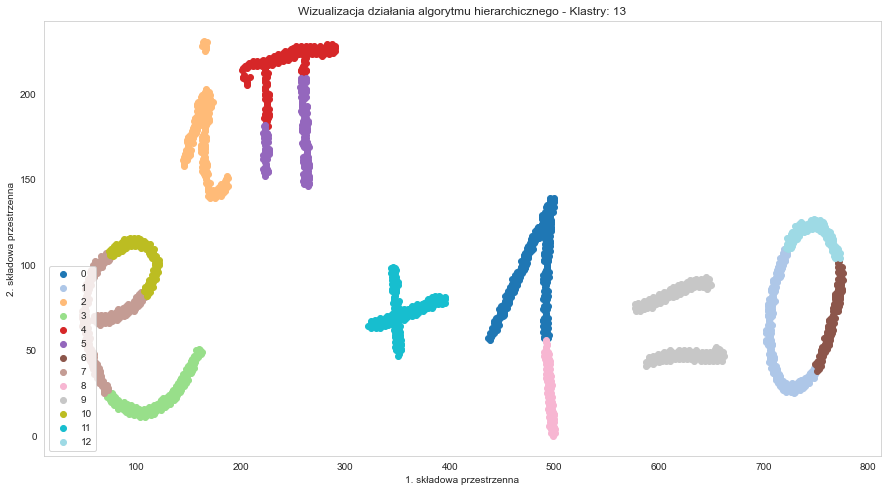

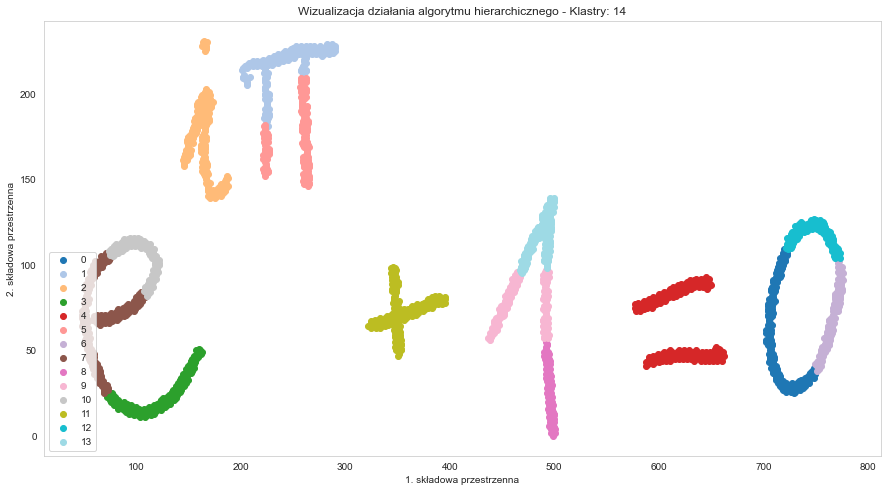

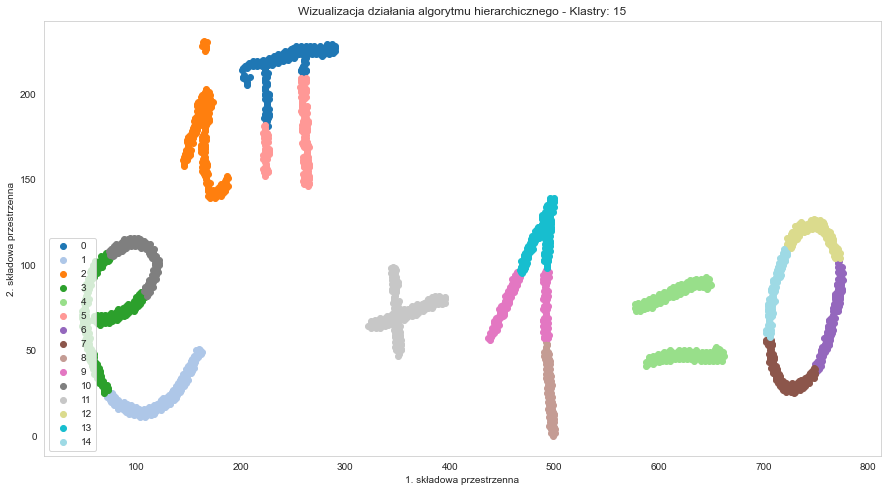

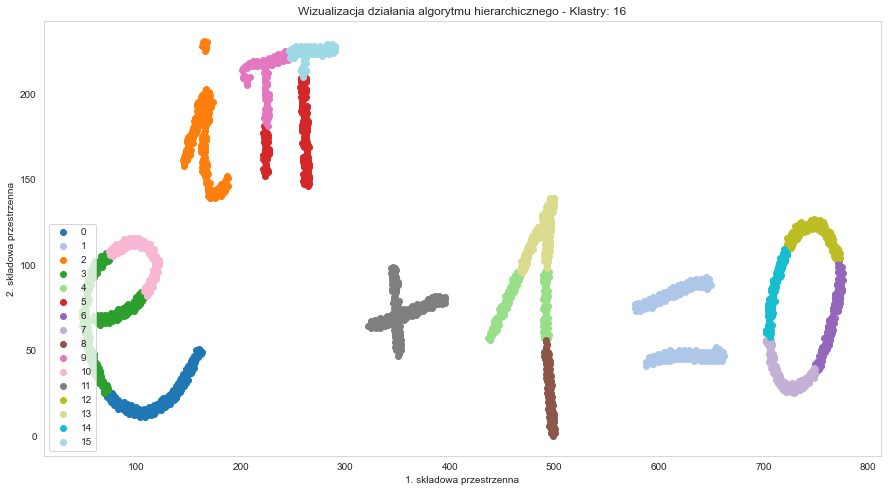

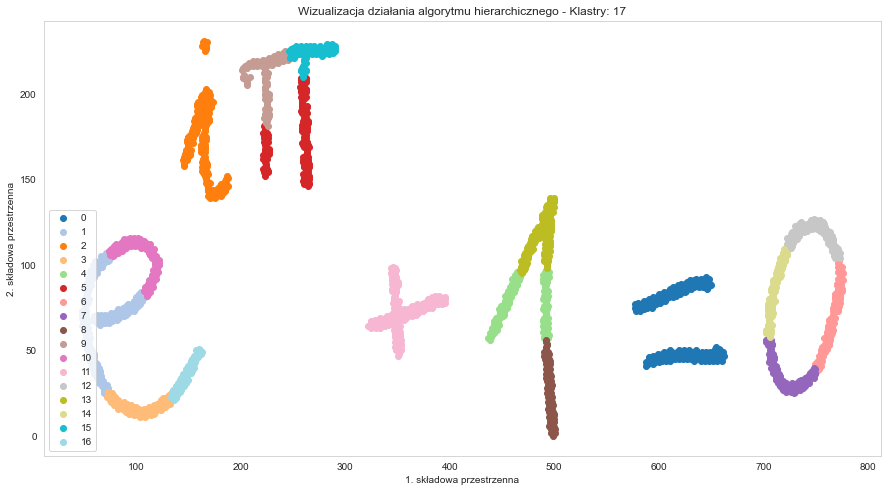

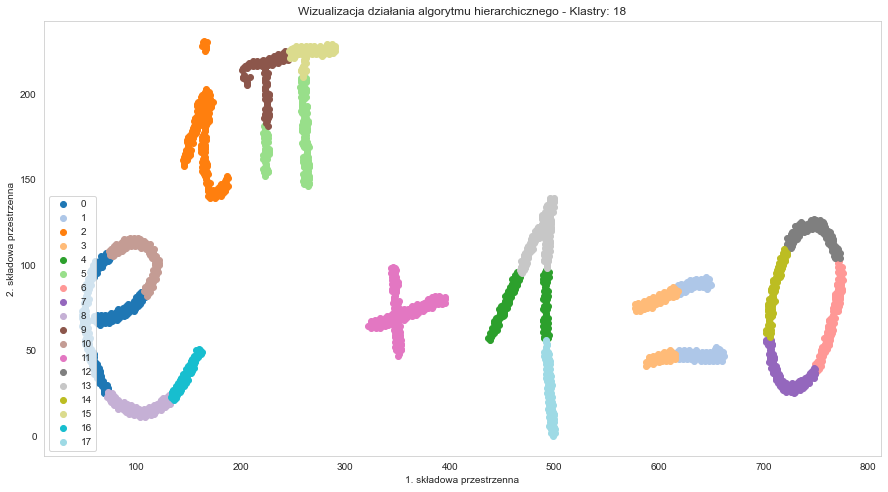

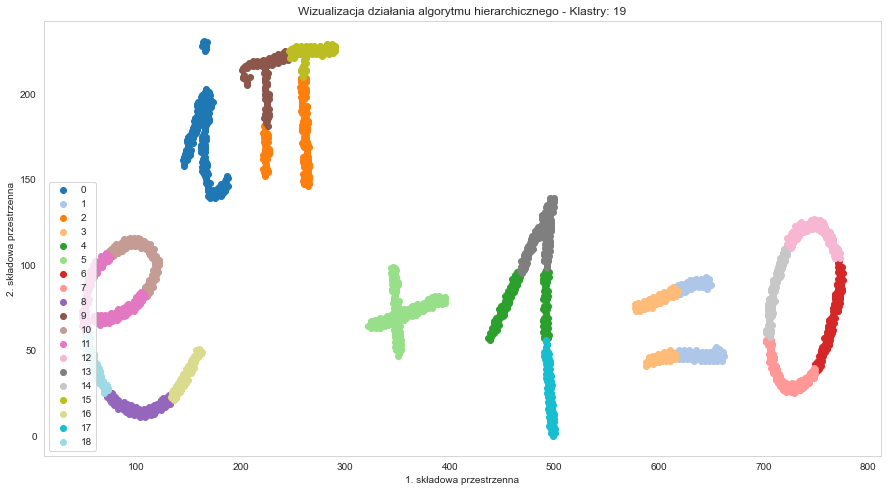

In [27]:
# Liczba klastrów, której się spodziewamy na podstawie wyglądu dendrogramu.
n_clusters = 4
for n_clusters in range(2, 20):
    # Wykonanie algorytmu hierarchicznego:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    clusterer.fit(dataset)

    # Zapisujemy sobie wynik przypisania danych do klastrów.
    agclust_predictions = clusterer.labels_

    # Wizualizacja za pomocą wcześniej wprowadzonej już funkcji plot_decision_regions.
    plt.figure(figsize=(15, 8))
    colors = cm.tab20(np.linspace(0, 1, len(np.unique(agclust_predictions))))
    # Narysujemy wykres punktowy z rozdzieleniem danych na klasy.
    for val, cv in zip(np.unique(agclust_predictions), colors):
        # Generujemy maskę za pomocą której wybierzemy punkty należące do każdej z klas.
        mask = agclust_predictions == val
        plt.scatter(dataset[mask, 0], dataset[mask, 1], label=val, color=cv)

    # Oznaczenia osi i pozostałe elementy wykresu.
    plt.xlabel('1. składowa przestrzenna')
    plt.ylabel('2. składowa przestrzenna')
    plt.title(f"Wizualizacja działania algorytmu hierarchicznego - Klastry: {n_clusters}")
    plt.grid()
    plt.legend(loc='lower left')

Widoczny jest dość równomierny podział loga, jednak także tutaj należy sprawdzić, czy możliwy jest lepszy efekt klasyfikacji, który pozwoli na oddzielenie od siebie liter w logi i okalającej je ramki.

## Algorytmy analizujące gęstość punktów
<p>Konieczność wyboru liczby klastrów jeszcze przed dokonaniem klasyfikacji bywa wymogiem problematycznym. Zmusza on to prowadzenia dodatkowych analizy mających na celu ustalenie optymalnej liczby klas. Z tego powodu opracowywane są także takie techniki, które nie mają takiego wymogu. Przykładem algorytmu tego typu jest algorytm DBSCAN. W uproszczeniu - jego zasada działania opera się na analizie gęstości punktów o wydzielaniu do osobnych klas skupisk punktów o wysokiej gęstości w porównaniu do gęstości punktów w przestrzeni, która te skupiska otacza. Stąd, jeżeli grupy punktów są dobrze od siebie odseparowane, to możliwe jest wykorzystanie tego typu algorytmu do oddzielenia od siebie skupisk punktów bez konieczności uprzedniego liczenia, np. ile znaków zawiera segmentowany napis. </p>

<p>Należy jednak pamiętać, że nawet taki algorytm, jak DBSCAN wymaga jednak specyficznych nastaw. W jego przypadku konieczne jest zwykle zdefiniowanie dwóch kluczowych wartości:</p>
<ul>
    <li/> minimalnej liczby punktów, która okala tzw. punkty rdzeniowe (ang. *core samples*), próbki te stanowią "zaczątki" klas generowanych przez algorytm DBSCAN (oznaczana w scikit-learn jako min_samples),
    <li/> maksymalnej odległości, w promieniu  której (licząc od punktów rdzeniowych) poszukiwane są punkty okalające punkty rdzeniowe (oznaczana w scikit-learn jako eps).
</ul>

<p>Oznacza to, że algorytm tworzy próbkę rdzeniową, jeżeli w promieniu o wartości eps od wybranego punktu w zbiorze danych znajduje się przynamniej min_samples innych punktów. Poszukiwanie takich próbek rdzeniowych jest kontynuowane do momentu aż nie będzie możliwe wyróżnienie nowych próbek rdzeniowych. Gdy już nie będzie możliwe znalezienie próbek rdzeniowych, to jeżeli jakiś punkt znajduje się w odległości mniejszej lub równej eps od punktu będącego próbką rdzeniową jakiegoś klastra, to przypisuje się go do właśnie tego klastra. Punkty, dla których nie udało się wykonać nawet takiego przypisania, pozostają nieprzypisane do żadnej klasy.</p>

<p>Umiejętny dobór wartości min_samples i eps pozwala na modyfikowanie zachowania się algorytmu, ich dobór często jest silnie powiązany z klasyfikowanym zbiorem danych, dlatego też w tym przykładzie, dobierzemy je eksperymentalnie, oceniając efekty segmentacji tekstu.</p>

Dodatkowe informacje i źródła na temat algorytmu DBSCAN są możliwe do znalezienia w [dokumentacji](https://scikit-learn.org/stable/modules/clustering.html#dbscan) biblioteki scikit-learn.

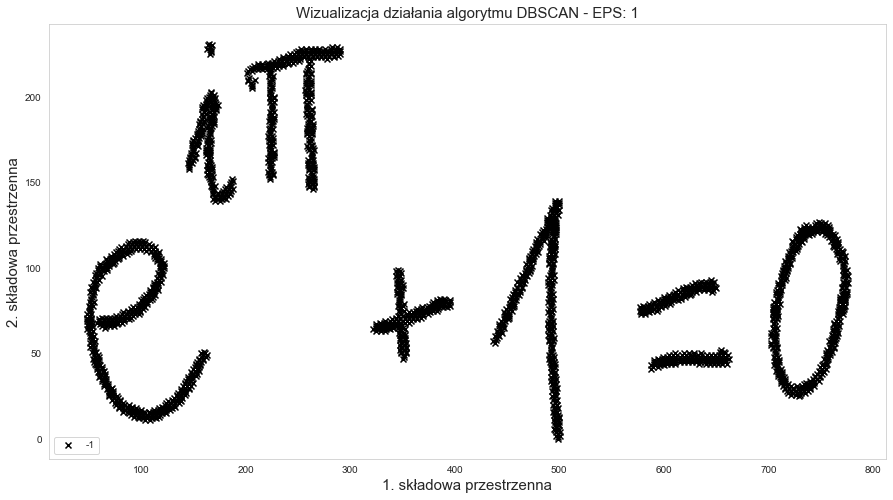

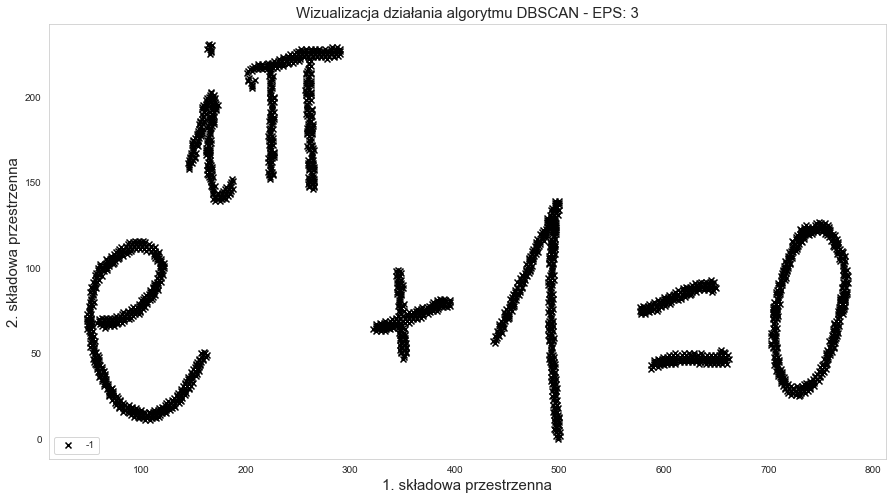

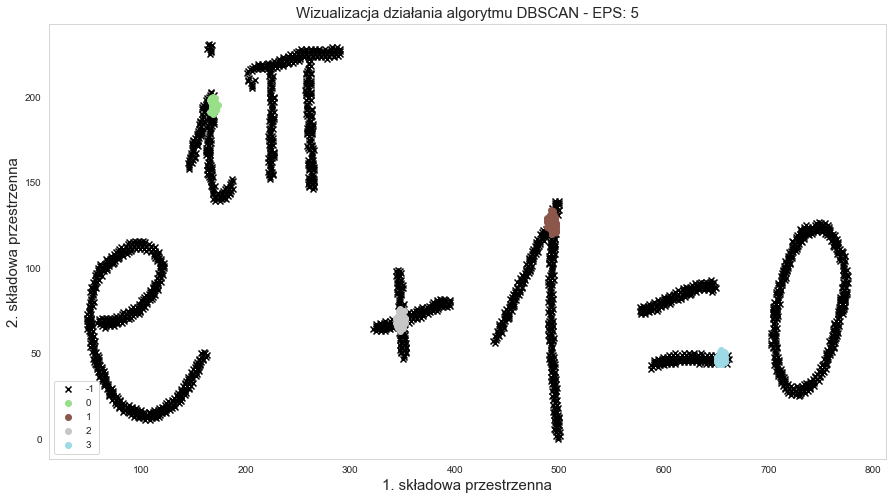

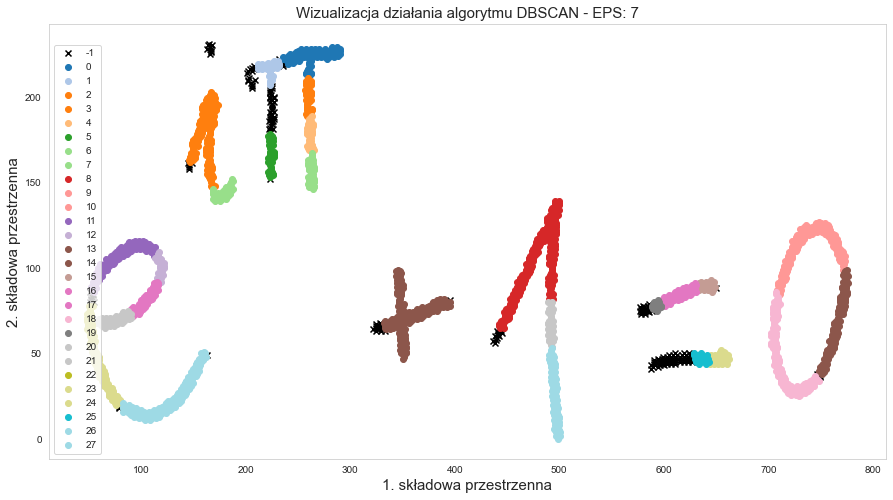

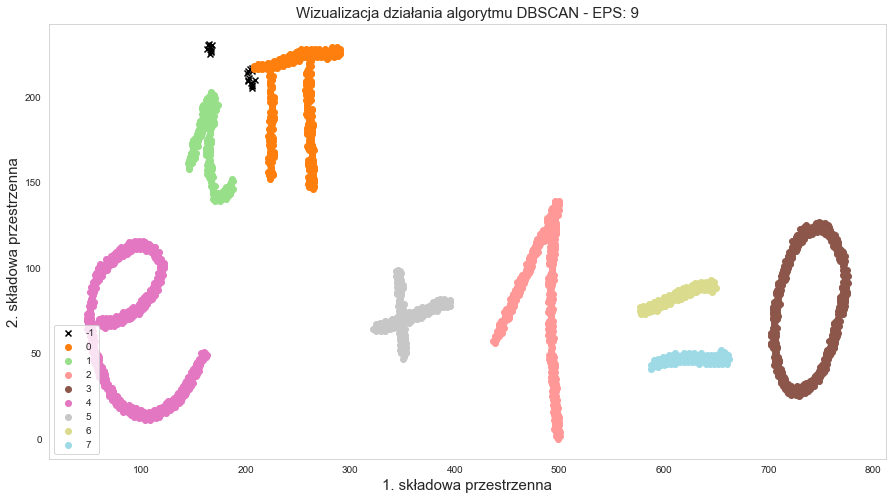

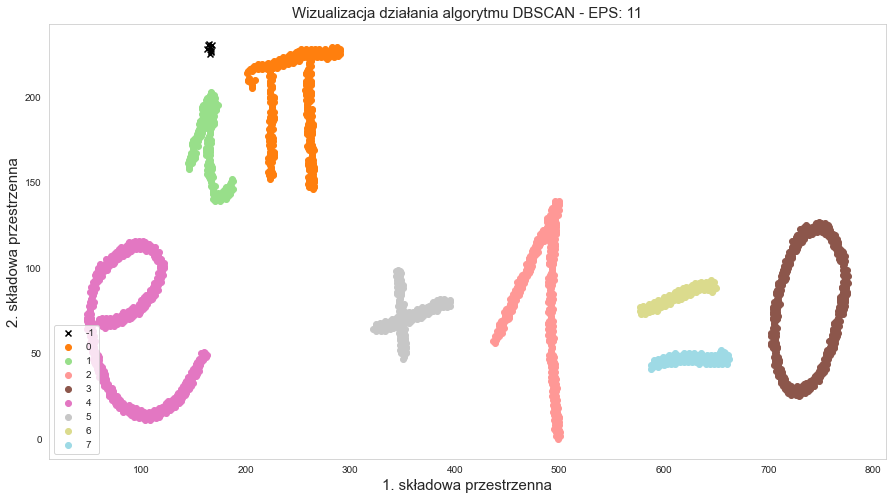

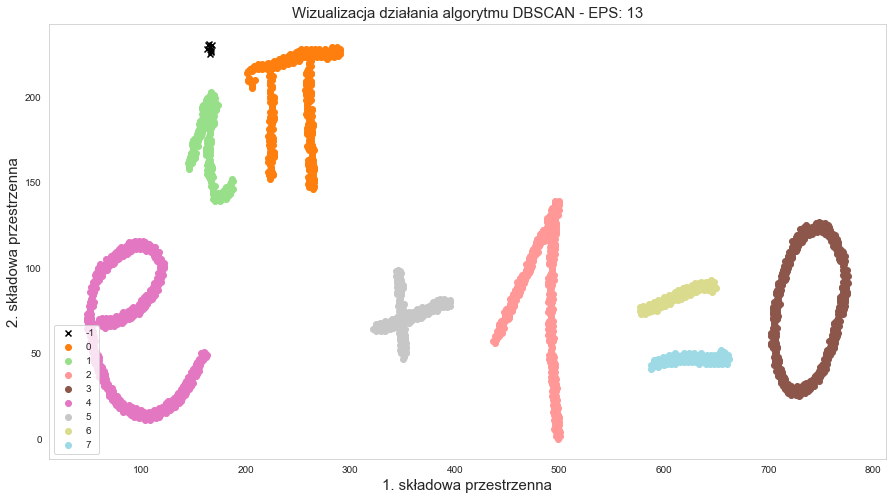

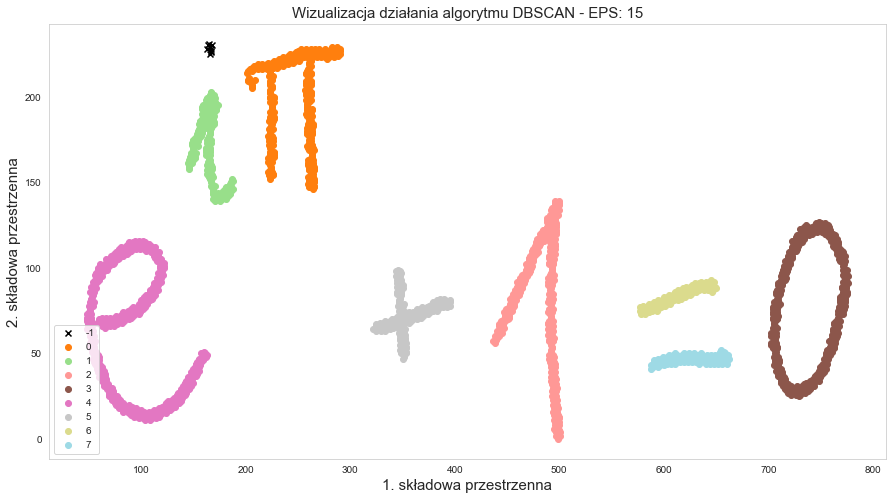

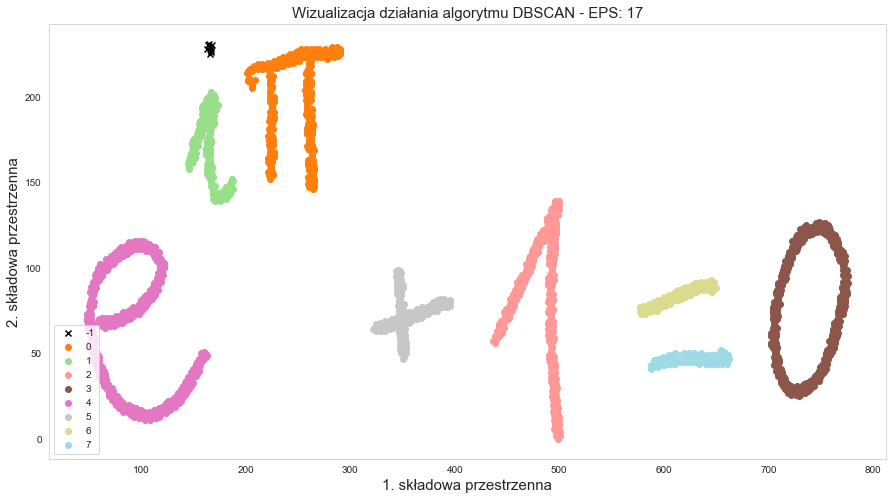

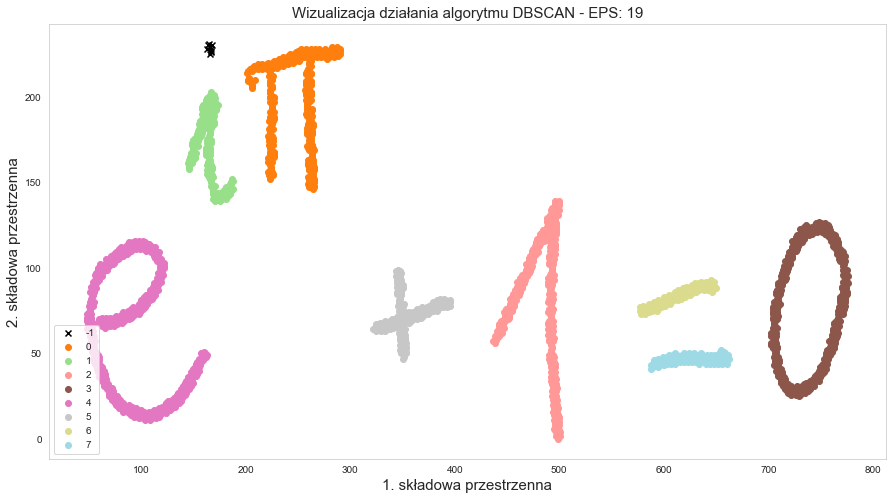

In [28]:
# Nastawy klasyfikacji nienadzorowanej algorytmem DBSCAN
min_samples = 20
eps = 60

for eps in range(1, 20, 2):
    # Wykonanie algorytmu DBSCAN
    clustering = DBSCAN(min_samples=min_samples, eps=eps).fit(dataset)
    dens_predictions = clustering.labels_

    # Wizualizacja za pomocą wcześniej wprowadzonej już funkcji plot_decision_regions.
    plt.figure(figsize=(15, 8))
    colors = cm.tab20(np.linspace(0, 1, len(np.unique(dens_predictions))))
    # Narysujemy wykres punktowy z rozdzieleniem danych na klasy.
    for val, cv in zip(np.unique(dens_predictions), colors):
        # Generujemy maskę za pomocą której wybierzemy punkty należące do każdej z klas.
        mask = dens_predictions == val
        # Dla tak wszystkich punktów wybranych za pomocą odpowiadającej danej klasie maski rysujemy wykres punktowy.
        if val == -1:
            c = 'black';
            marker = 'x'
        else:
            c = cv;
            marker = 'o'
        plt.scatter(dataset[mask, 0], dataset[mask, 1], label=val, color=c, marker=marker)

    # Oznaczenia osi i pozostałe elementy wykresu.
    plt.xlabel('1. składowa przestrzenna', fontsize=15)
    plt.ylabel('2. składowa przestrzenna', fontsize=15)
    plt.title(f"Wizualizacja działania algorytmu DBSCAN - EPS: {eps}", fontsize=15)
    plt.grid()
    plt.legend(loc='lower left')

Efektem wykonania algorytmu DBSCAN z obecnymi wartościami nastaw jest zaklasyfikowanie całego zbioru punktów do pojedynczego klastra. Oznacza to, że prawdopodobnie parametr eps jest za duży i pozwala on na "przeskoczenie" poszukiwania sąsiednich punktów przez przerwy oddzielające od siebie poszczególne znaki loga. Warto zatem rozpocząć poszukiwania lepiej sprawdzających się nastaw od zmniejszenia tego parametru.

# Zadania do wykonania

## Zadanie 1.
Obecne zbiory nastaw algorytmów klasyfikacji nienadzorowanej nie okazały się zbyt skuteczne w realizacji zadania segmentacji znaków w przykładowym, ręcznie narysowanym logu. Poszukaj lepszych nastaw algorytmów i postaraj się możliwie najdokładniej rozdzielić litery i ramkę loga poprzez zaklasyfikowanie ich do oddzielnych klas za pomocą badanych w przykładzie algorytmów.

<ol>
    <li/> Czy wszystkie algorytmy poradziły sobie równie dobrze w zadaniu segmentacji pisma? Jakie problemy z segmentacją pisma udało Ci się zaobserwować?
    <li/> Jeśli jakiś algorytm nie poradził sobie w zadowalającym stopniu z tym zadaniem, dlaczego mogło się tak stać? Podobnie w przypadku algorytmów, którym udało się dokonać segmentacji - dlaczego akurat taki dobór nastaw okazał się najbardziej skuteczny?
    <li/> Czy wygodniejsze do zadania segmentacji pisma są algorytmy wymagające znajomości liczby klastrów, czy te bazujące na gęstości punktów? Czy może istnieją Twoim zdaniem zastosowania, w których jedne z nich spisują się lepiej i na odwrót?
</ol>

## Zadanie 2.
Zamień teraz plik wejściowy na plik "wzor_matematyczny.png". Uruchom ponownie (<b>pozostawiając nastawy algorytmów, wprowadzone przez Ciebie w zadaniu 1.</b>) wszystkie algorytmy klasyfikacji nienadzorowanej. Następnie, jeżeli któryś z algorytmów wymaga poprawienia nastaw, zmień je tak, aby znowu uzyskać rozdzielenie liter na osobne klasy.

<ul>
    <li/> Czy był taki algorytm, który nie wymagał zmiany nastaw aby poprawnie dokonać segmentacji pisma?
    <li/> Jakie nowe problemy pojawiły się w przypadku segmentacji symboli matematycznych? Jakie poprawki lub jakie dodatkowe przetwarzanie należy jeszcze dodać, jeżeli efekt segmentacji z ćwiczenia miałby posłużyć np. do segmentacji znaków na potrzeby systemu rozpoznawania liter (OCR)?
    <li/> Jakie zalety i wady ma Twoim zdaniem algorytm DBSCAN, jeśli porównać go z algorytmem k średnich i hierarchicznym?
</ul>

![stopka.svg](stopka.svg)